# Анализ рекламной кампании Procrastinate Pro+

Проект призван выявить проблемы в рекламной кампании Procrastinate Pro+. 
Итогом проекта должны стать, во-первых, выявленный проблемы в проведении рекламы. Во-вторых, выыявление перспективных точек роста и рекомендаций аналитикам.

Нам предстоит:

- загрузить и предобработать данные;

- Написать функции для расчёт различных метрик и составления графиков;

- Создать профили пользователей;

- Посмотреть затраты на рекламную компанию и расчитать CAC для пользователей;

- Оценить количество платящих пользователей по стране/устройству/рекламному каналу;

- Построить графики удержания, конверсии, LTV, ROI и проанализировать их;

- Написать выводы.

## Шаг 1. Загрузим данные и подготовим их к анализу
Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа. Убедимся, что тип данных в каждой колонке — правильный. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [3]:
try:
    visits, orders, costs = (pd.read_csv('/datasets/visits_info_short.csv'),  
                             pd.read_csv('/datasets/orders_info_short.csv'),  
                             pd.read_csv('/datasets/costs_info_short.csv'))
except:
    visits, orders, costs = (pd.read_csv('C:/Users/Пользователь/Downloads/visits_info_short.csv'),  
                             pd.read_csv('C:/Users/Пользователь/Downloads/orders_info_short.csv'),  
                             pd.read_csv('C:/Users/Пользователь/Downloads/costs_info_short.csv'))

In [5]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

Проверим датасеты на наличие дупликатов.

In [6]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


Дубоикатов не обнаружили.

In [7]:
visits['session_start'] = pd.to_datetime(visits['Session Start'])
visits['session_end'] = pd.to_datetime(visits['Session End'])
orders['event_dt'] = pd.to_datetime(orders['Event Dt'])

In [8]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

Типы данных (дата/время) поправили. Проаусков нет. Аромалий в данных не обнаружили. Двигаемся дальше.

## Шаг 2. Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии

Напишем функцию для создания профилей пользователей. 

In [9]:
def get_profiles(visits, orders, ad_costs, event_names=[]):

  
    profiles = (
        visits.sort_values(by=['User Id', 'session_start'])
        .groupby('User Id')
        .agg(
            {
                'session_start': 'first',
                'Channel': 'first',
                'Device': 'first',
                'Region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    
    profiles['payer'] = profiles['User Id'].isin(orders['User Id'].unique())

    
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['User Id'].isin(
                events.query('event_name == @event')['User Id'].unique()
            )

 
    new_users = (
        profiles.groupby(['dt', 'Channel'])
        .agg({'User Id': 'nunique'})
        .rename(columns={'User Id': 'unique_users'})
        .reset_index()
    )

   
    ad_costs = ad_costs.merge(new_users, on=['dt', 'Channel'], how='left')

    
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    
    profiles = profiles.merge(
        ad_costs[['dt', 'Channel', 'acquisition_cost']],
        on=['dt', 'Channel'],
        how='left',
    )

    
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Напишем функцию для расчёта удержания пользователей. 

In [10]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    
    dimensions = ['payer'] + dimensions

   
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

  
    result_raw = result_raw.merge(
        visits[['User Id', 'session_start']], on='User Id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days


    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='User Id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

  
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

   
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    
    return result_raw, result_grouped, result_in_time 

Напишем функцию для расчёта конверсии пользователей. 

In [11]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    
    first_purchases = (
        orders.sort_values(by=['User Id', 'event_dt'])
        .groupby('User Id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    
    result_raw = result_raw.merge(
        first_purchases[['User Id', 'event_dt']], on='User Id', how='left'
    )

    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='User Id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    if 'cohort' in dimensions: 
        dimensions = []

    
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

   
    return result_raw, result_grouped, result_in_time 

Напишем функцию для расчёта пожизненной ценности пользователей (все клиенты бесценны). 

In [12]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
   
    result_raw = result_raw.merge(
        orders[['User Id', 'event_dt', 'Revenue']], on='User Id', how='left'
    )
 
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    
    def group_by_dimensions(df, dims, horizon_days):
        
        result = df.pivot_table(
            index=dims, columns='lifetime', values='Revenue', aggfunc='sum'
        )
        
        result = result.fillna(0).cumsum(axis=1)
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        result = result.div(result['cohort_size'], axis=0)
       
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        result['cohort_size'] = cohort_sizes

        
        cac = df[['User Id', 'acquisition_cost'] + dims].drop_duplicates()

       
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        
        roi = result.div(cac['cac'], axis=0)

       
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        
        roi['cohort_size'] = cohort_sizes

        
        roi['cac'] = cac['cac']

        
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        
        return result, roi

    
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    
    if 'cohort' in dimensions:
        dimensions = []

    
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  
        result_grouped,  
        result_in_time, 
        roi_grouped,  
        roi_in_time,  
    ) 

Напишем функцию-фильтр для построения графиков.

In [13]:
def filter_data(df, window):
    
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

Напишем функциюпостроения графика удержания пользователей.

In [14]:
def plot_retention(retention, retention_history, horizon, window=7):

   
    plt.figure(figsize=(15, 10))

    
    retention = retention.drop(columns=['cohort_size', 0])
    
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    
    ax3 = plt.subplot(2, 2, 3)
    
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

Напишем функциюпостроения графика конверсии пользователей.

In [15]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    
    plt.figure(figsize=(15, 5))

    
    conversion = conversion.drop(columns=['cohort_size'])
    
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Напишем функцию построения графика пожизненной ценности и окупаемости привлечения пользователей.

In [16]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    
    plt.figure(figsize=(20, 10))

    
    ltv = ltv.drop(columns=['cohort_size'])
    
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    
    cac_history = roi_history[['cac']]

    
    roi = roi.drop(columns=['cohort_size', 'cac'])
    
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

   
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Шаг 3. Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [18]:
profiles = get_profiles(visits, orders, costs)

profiles.head(5)

,User Id,first_ts,Channel,Device,Region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную дату привлечения клиентов.

In [19]:
max_acquitision_dt = profiles['dt'].max()

max_acquitision_dt

datetime.date(2019, 10, 27)

In [20]:
min_acquitision_dt = profiles['dt'].min()
min_acquitision_dt

datetime.date(2019, 5, 1)

Построим таблицу с долей пользователей-плательщиков из каждой страны.

In [21]:
region_grouped = profiles.groupby('Region').agg({'User Id': 'count', 'payer': 'sum'})
region_grouped['Доля платящих'] = region_grouped['payer'] / region_grouped['User Id']
region_grouped.sort_values(by='Доля платящих', ascending=False)

,User Id,payer,Доля платящих
Region,,,
United States,100002,6902,0.069019
Germany,14981,616,0.041119
UK,17575,700,0.039829
France,17450,663,0.037994


Мы работаем с пользователями из четырёх стран: Великобритания, Германия, США И Франция. Больше всего платящих пользователей (лидов) приносит США -  в разы больше, чем остальные страны вместе взятые. Меньше всего - Германия.

In [22]:
device_grouped = profiles.groupby('Device').agg({'User Id': 'count', 'payer': 'sum'})
device_grouped['Доля платящих'] = device_grouped['payer'] / device_grouped['User Id']
device_grouped.sort_values(by='Доля платящих', ascending=False)

,User Id,payer,Доля платящих
Device,,,
Mac,30042,1912,0.063644
iPhone,54479,3382,0.062079
Android,35032,2050,0.058518
PC,30455,1537,0.050468


Пользователь пользуются мобильными и декстопными устройствами. Больше всего лидов заходит с мобилок (iPhone и Android), меньшая часть - с декстопов. 

In [23]:
channel_grouped = profiles.groupby('Channel').agg({'User Id': 'count', 'payer': 'sum'})
channel_grouped['Доля платящих'] = channel_grouped['payer'] / channel_grouped['User Id']
channel_grouped.sort_values(by='Доля платящих', ascending=False)

,User Id,payer,Доля платящих
Channel,,,
FaceBoom,29144,3557,0.122049
AdNonSense,3880,440,0.113402
lambdaMediaAds,2149,225,0.104700
TipTop,19561,1878,0.096007
RocketSuperAds,4448,352,0.079137
WahooNetBanner,8553,453,0.052964
YRabbit,4312,165,0.038265
MediaTornado,4364,156,0.035747
LeapBob,8553,262,0.030633


В датафрейме поименованны 11 каналов. Есть два интересных момента. Во-первых, достаточно много лидов приходят сами, без рекламы (органики). Этот канал находится на третьем месте, что ставит авопросы к остальным рекламным источникам об эффектиности. 
Во-вторых, много пользователей приходит через FaceBoom и TipTop. Это и хорошо, и нужно смотреть на CAC этих каналов. В-третьих, Достаточно высокую долю лидов приносят AdNonSense и LambdaMedaAds, больше чем "дорогой" TipTop. 

## Шаг 4. Маркетинговые измерения

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [24]:
display('Денег на рекламу потрачено {}'.format(sum(costs['costs'])))
costs_group = costs.groupby('Channel').agg('sum').sort_values('costs', ascending=False)
costs_group['share'] = (costs_group['costs'] / (sum(costs['costs'])))
costs_group

'Денег на рекламу потрачено 105497.30000000012'

,costs,share
Channel,,
TipTop,54751.30,0.518983
FaceBoom,32445.60,0.307549
WahooNetBanner,5151.00,0.048826
AdNonSense,3911.25,0.037074
OppleCreativeMedia,2151.25,0.020392
RocketSuperAds,1833.00,0.017375
LeapBob,1797.60,0.017039
lambdaMediaAds,1557.60,0.014764
MediaTornado,954.48,0.009047


Видим, что половину рекламного бюджета съел TipTop, а треть - FaceBoom. Пользователи, пришедшие оттуда, должны быть "золотыми"...

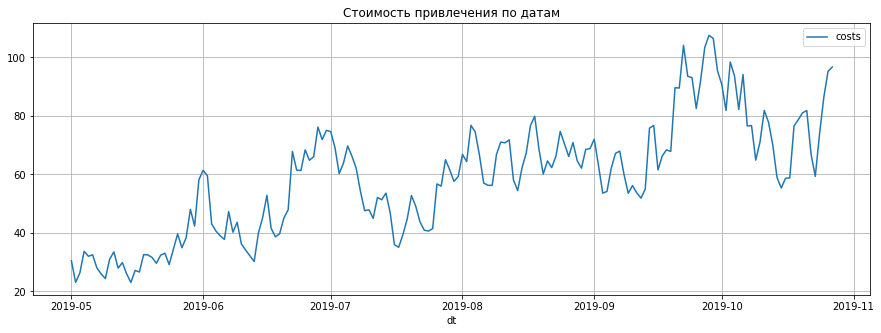

In [25]:
cost_by_date = costs.groupby('dt').agg('mean').sort_values('costs', ascending=False)

cost_by_date.plot(grid=True, figsize=(15, 5))
plt.title('Стоимость привлечения по датам')
plt.show(); 

Видим, траты на привлечение новых пользователей с мая по октябрь выросли в несколько раз. Новые клиенты должны приносить очень солидный профит, чтобы покрыть такую рекламную кампанию. 

Расчистаем среднюю стоимость привлечения для каждого канала.

In [26]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 10, 27).date(), 7, dimensions=['Channel']
)



ltv_profiles = profiles.query('dt <= @max_acquitision_dt')

ltv_profiles.groupby('dt').agg({'User Id': 'nunique'})

cac = (
    ltv_profiles.groupby('Channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)

display(cac.sort_values('cac', ascending=False))

,cac
Channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


In [27]:
mean_cac = profiles.query('Channel != "organic"')

display(mean_cac['acquisition_cost'].mean())

1.127481323942928

CAC для пользователей из TipTop и FaceBoom ожидаемо высокий. Однако он также достаточно высокий для AdNonSense, LambdaMediaAds, WahooNetBanner. Однако является ли реклама эффективной или нет покажет метрики LTV и ROI.  

Средний CAC для одно пользователя составляет 1.12

## Шаг 5. Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Опишим проблемы, которые мы обнаружили. Ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишим возможные причины обнаруженных проблем и сформируем рекомендации для рекламного отдела. 

### Проанализируем общую окупаемость рекламы

In [28]:
observation_date = datetime(2019, 11, 1).date()  
horizon_days = 14

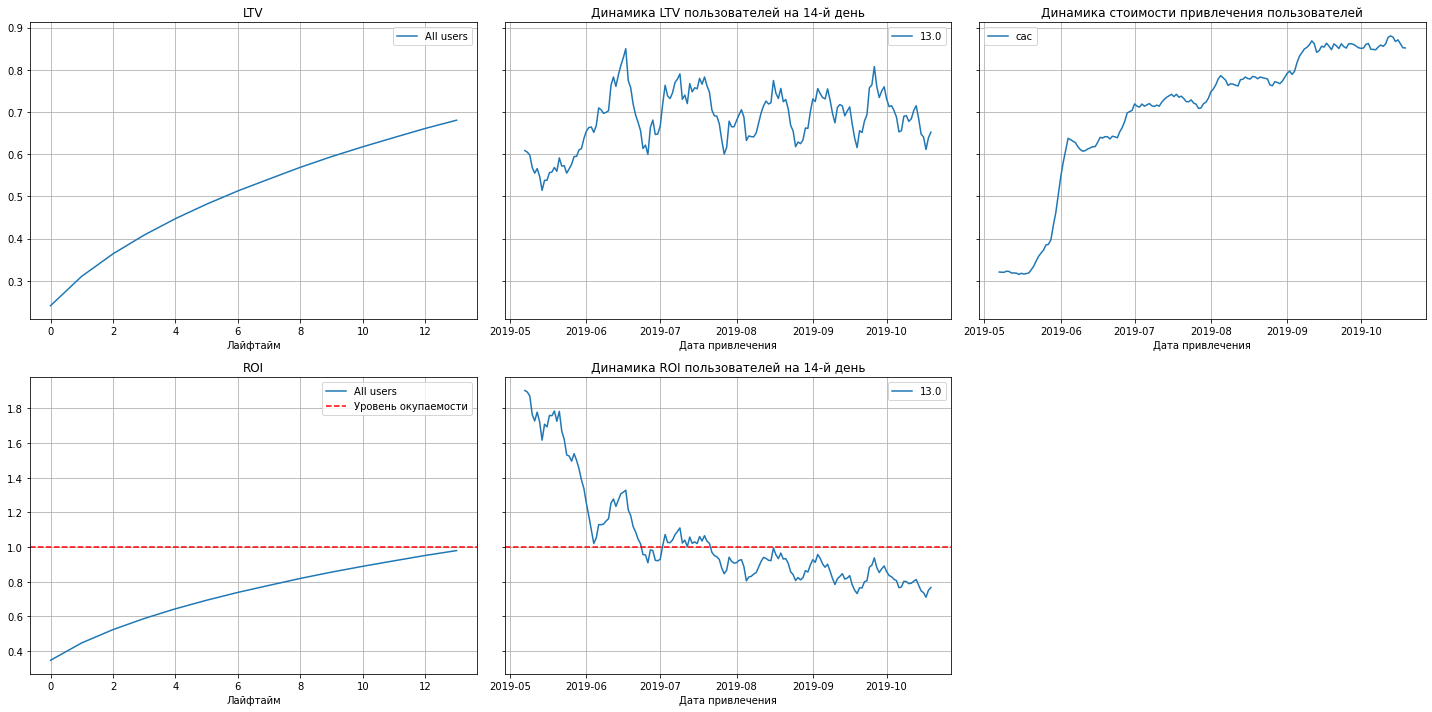

In [29]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

На графиках видим: 

- За референтный период CAC вырос почти троекртано.

- ROI ещё летом пересёк линию окупаемости и продолжает падать. 

- LTV растёт, но ниже линии лкупаемости. Иными словами, ROI падает быстрее, чем растёт LTV.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

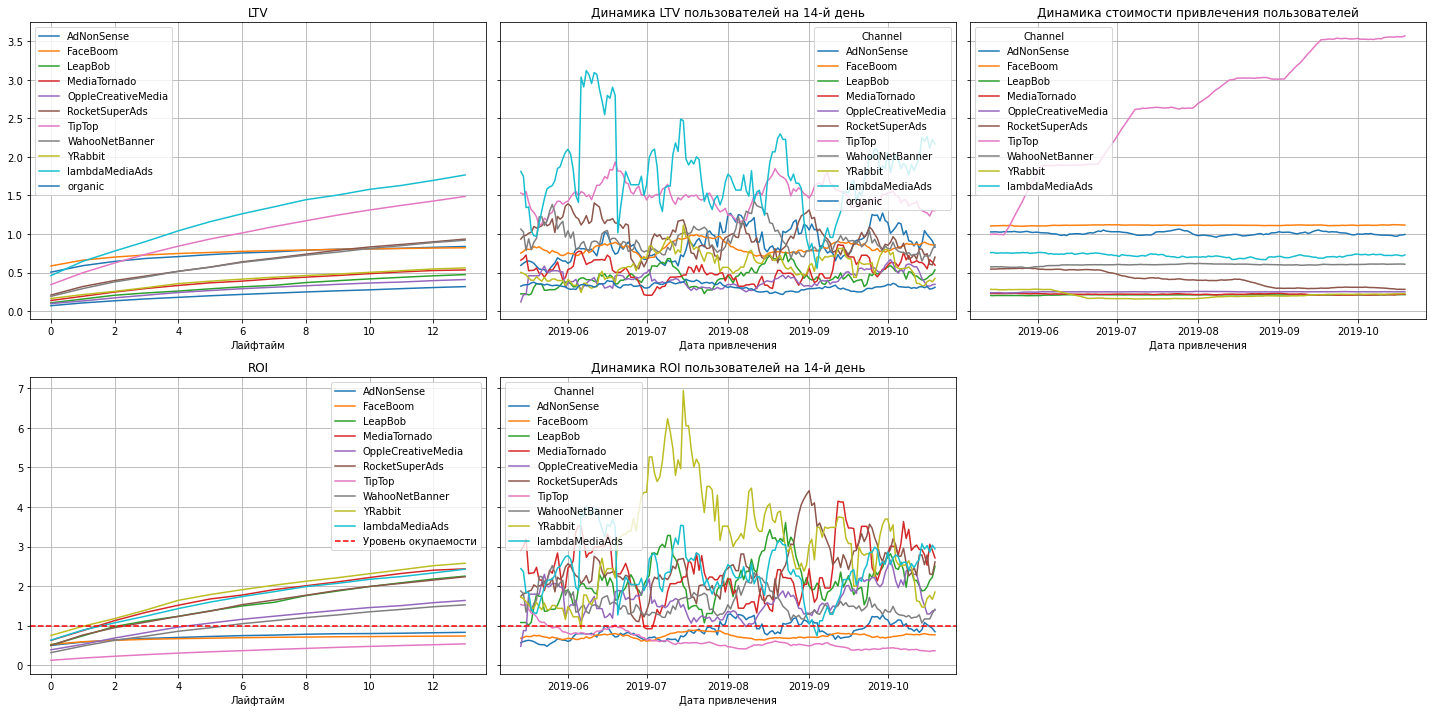

In [30]:
dimensions = ['Channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

На графиках видим:

- Хороший рост LTV демонстрируют lambdaMediaAds, YRAbbit, MediaTornado и TipTop.Однако отметим, что последний - это самый дорогой канал.

- Хороший рост ROI демонстрируют lambdaMediaAds, YRAbbit, MediaTornado и WahooNetBanner.А вот самые дорогие FaceBoom, AdNonSense и TipTop не окупаются. 

- Стоимость привлечений TipTop стабильно и быстро растёт.

Посмотрим на удержание и конверсию по калам привлечения.

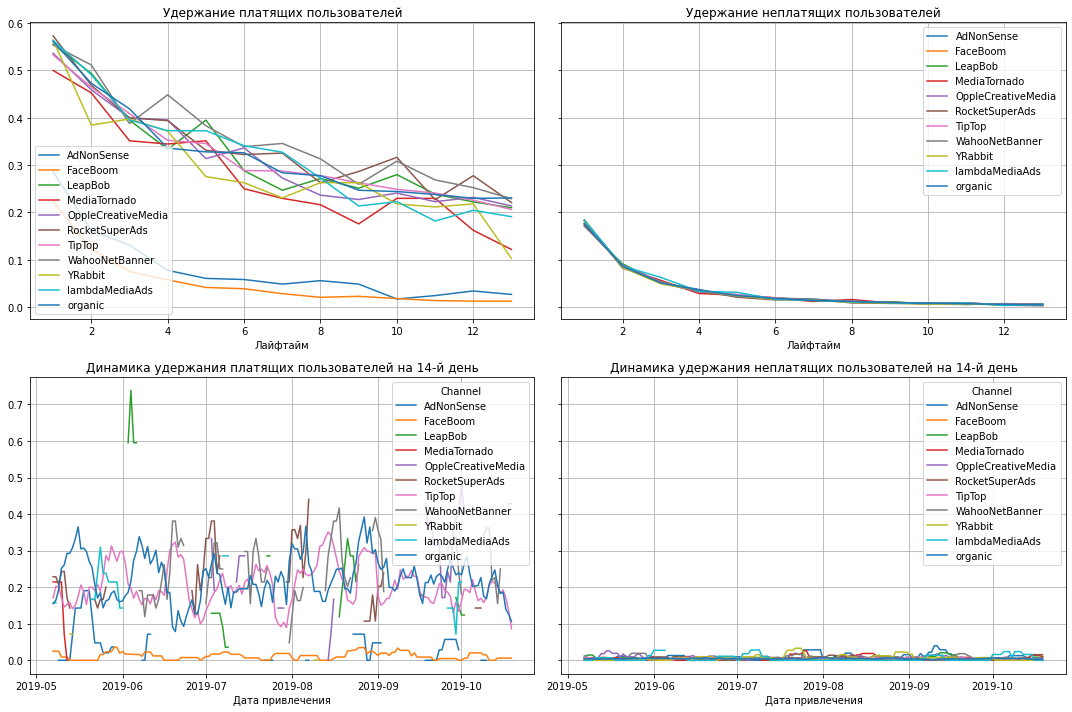

In [31]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Пользователи с FaceBoom, привлечённые за дорого, удерживаются хуже всего. Особенно это видно по лидам. Такжу очень плохо удерживаются пользователи привлечённые AdNoneSense 

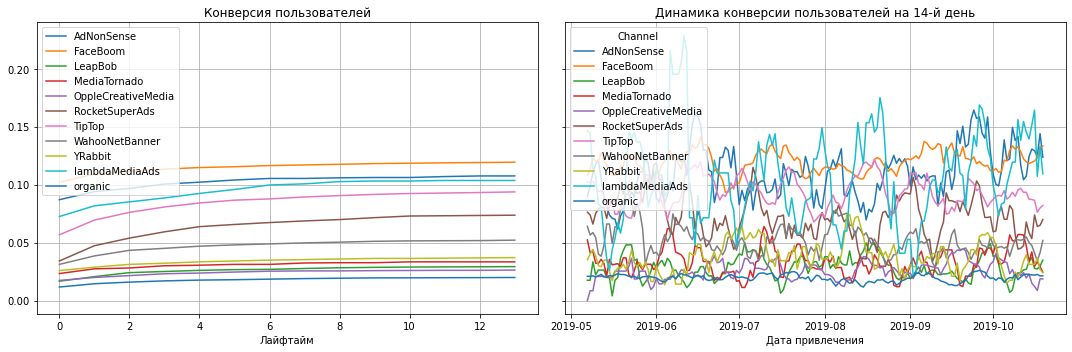

In [32]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

На графике видим, что конверсятся пользователи с FaceBoom лучше всего. Это также справедливо для: AdNoneSense, LambdaMedia Ads и TipTop

### Проанализируем окупаемость рекламы с разбивкой по странам

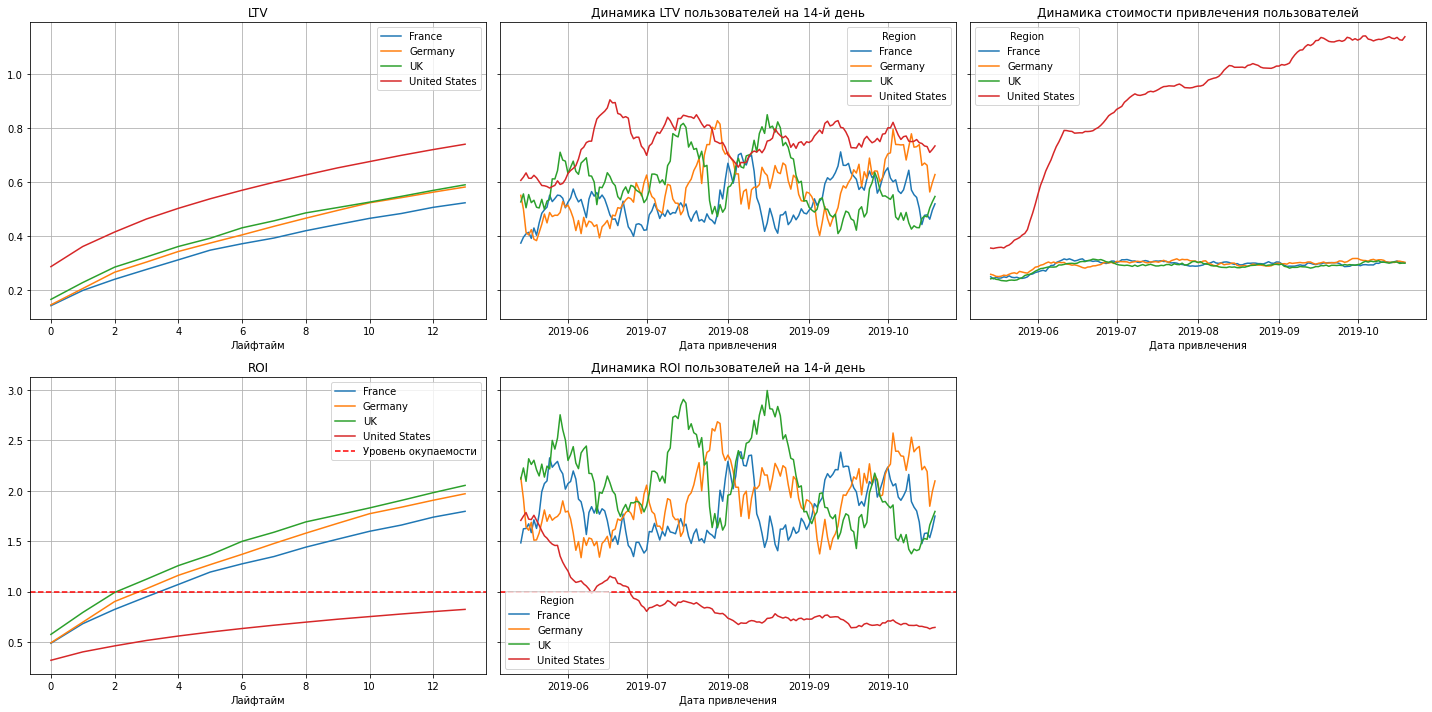

In [33]:
dimensions = ['Region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

##### На графика видим, что все проблемы из-за США...

- Растёт динамика стоимости пользователей из США. Она выросал почти в 3 раза, при том, что CAC по другим странам вырос незначительно.

- Привлечение американцев не окупается за 14 дней, а европейцев - за 2-3 дня. К 14-му дню европеец в среднем приносит от 50 до 60% прибыли. А окупаемость американцев на уровне 65%. 

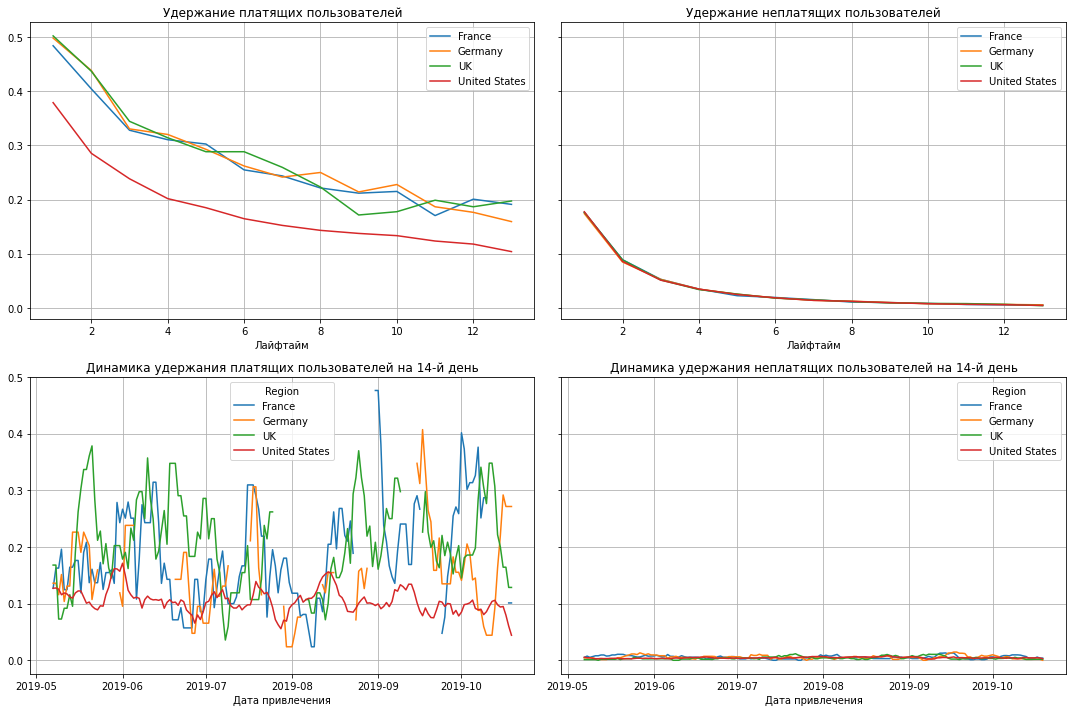

In [34]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

На графиках видим, что удержание лидов из США происходит в два руже хуже, чем в Великобритании и США. 

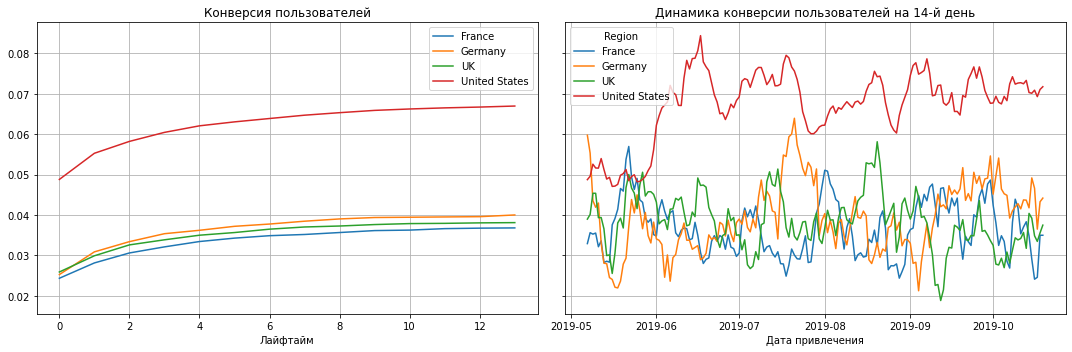

In [35]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

На графиках видим, что пользователи из США конверсятся лучше остальных.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

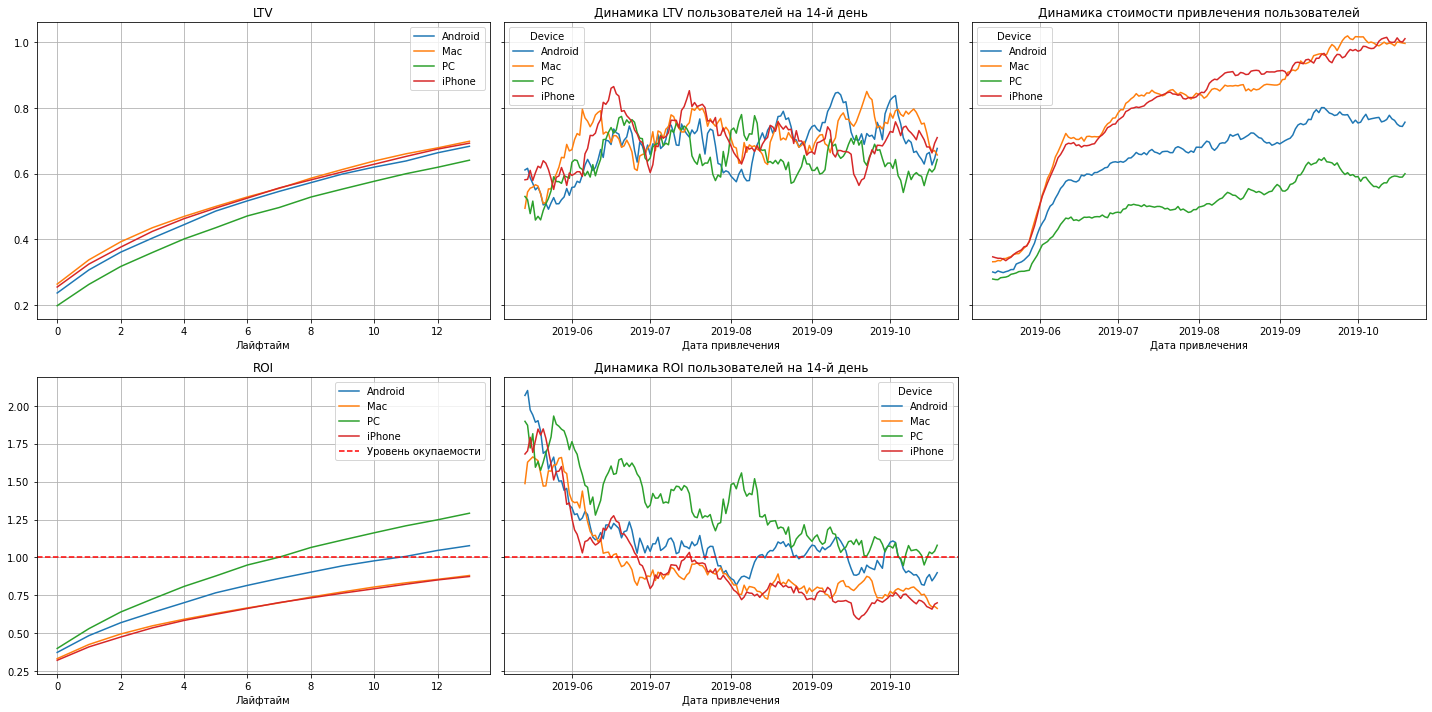

In [36]:
dimensions = ['Device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

На графиках видим: 

- Стоимость прилечения выросла для всех устройств, но быстрее всего на "яблочных" платформах. 

- Пользоваетли на ПК окупаются на 7-ой день. "Яблочные" устройсва окупаются лишь приблизительно на 75%. Android на 85%. 

- Во временном разрезе ROI всех устройств падает. MAC не выходит в "плюс" с середины июня, iPhone - с середины июля, Android и ПК, при существующей динамике, с октября. 

Взглянем на конверсию и удержание.

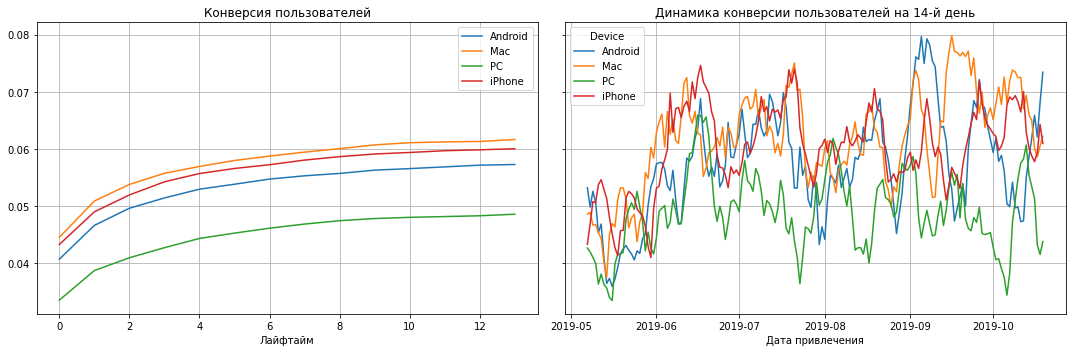

In [37]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам пользователи на мобильных платформах и МACOS конверсятся достаточно хорошо. 

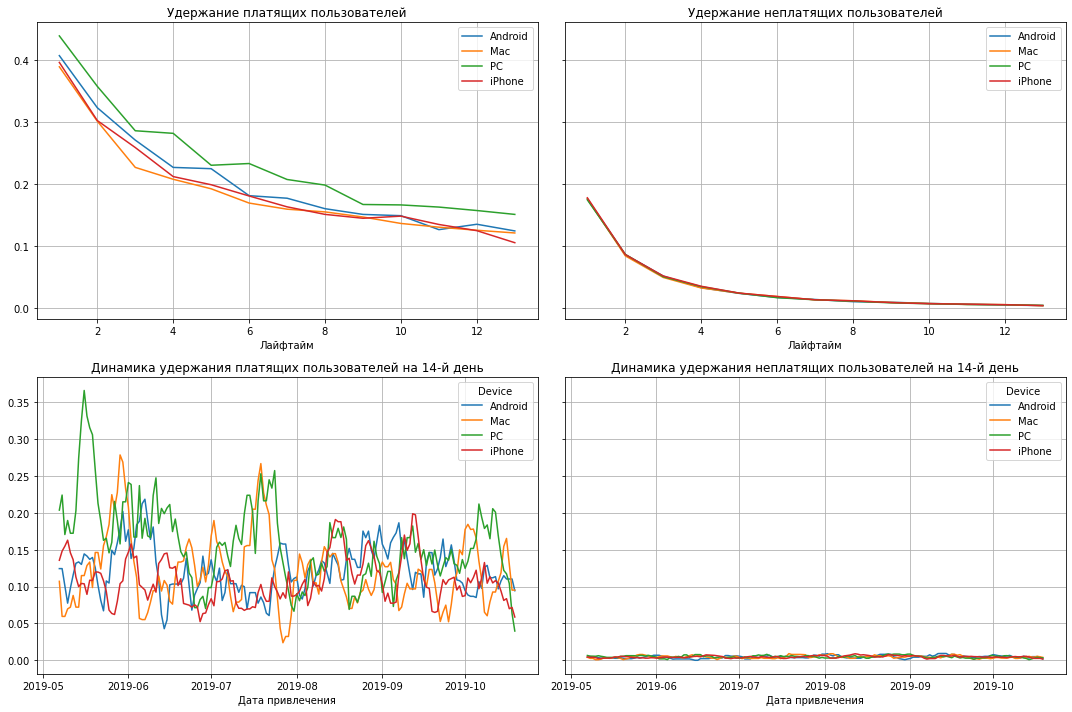

In [38]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Уровень удержания для всех пользователей одинаковый. 

## Выводы

__Главная причина убыточности компании - это дорогая рекламная кампания через TipTop и FaceBoom, нацеленная на североамериканцев, пользователей устройств Apple. Затраты на привлечение новых пользователей выше, чем доход от их покупок__

__Рекламная кампания в США не окупается из-за:__

- Высокой стоимости привлечения одного пользователя. На долю TipTop и FaceBoom приходится 82.5% всего рекламного бюджета. При этом CAC для первого 2.8, а для второго - 1.1, при среднем CAC проекта 0.75;

- Низкого уровня удержания как всех пользователей, так и платящих. Уровень удержания остаётся достаточно высоким.

При этом конверсия в США достаточно высокая. НО! Нужно учитывать, что и пользователей из США в 2.5 раза больше, чем из других стран вместе взятых. 

Лиды, привлеченные через FaceBoom и  AdNoneSense удерживаются плохо, а они приносят свыше 10% платящих пользователей. Малая часть из них доживает до 14-го дня, который заявлен как сроко окупаемости. 

Для канала TipTop растёт стоимость привлечения одного пользователя, которая не окупается. По уровню привлечения платящих пользователей TipTop лишь четвёртый, но обин съедает половину рекламного бюджета. 

Самая привлекательная себестоимость привлечения пользователей в Европе, особенно в Соединённом Королевстве. 

ВАЖНО! Что окупаемость пользователей выходит "в ноль" только на 14 день жизни, до которого многие пользователи не дотягивают. 

Нужно снижать затраты на привлечение пользователей, при увеличении уровня удержания. В первую очередь это касается США.

### Рекомендации для отдела маркетинга

- Перестать покупать рекламу на FaceBoom, TipTop и AdNoneSense.

- По отношению ROI - lambdaMediaAds, YRAbbit, MediaTornado и WahooNetBanner - самые эффектиные каналы.

- Уменьшить масштаб рекламной кампании в США. 

- Перспективные точки роста находятсяв Европе. Прежде всего, в Великобритании. 

- Переключить фокус с пользователей "яблочных" устройств на ПК и Android. 